In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import  Dataset
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import random
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import kagglehub
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

writer = SummaryWriter('runs/project')

/home/lr/Documents/github/AILab/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the dataset


path_set_1 = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')
path_set_2 = kagglehub.dataset_download('amandam1/healthy-vs-diseased-leaf-image-dataset')

path_set_1 = os.path.join(path_set_1, 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)')

print (f"Path set 1: '{path_set_1}'")
print (f"Path set 2: {path_set_2}")

Path set 1: '/home/lr/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
Path set 2: /home/lr/.cache/kagglehub/datasets/amandam1/healthy-vs-diseased-leaf-image-dataset/versions/1


## Dataset Hyperparams

In [3]:
# Trainingsdata params
random_erase=0.1
scale_factor = 28
batch_size = 64
width = 224
height = 224


# Leave this on False ... 70.000 images will crash the RAM
move_to_cuda_preprocess = False


In [4]:
# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224, padding=4),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [5]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir=".", transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.labels_df.iloc[idx, 2] if 'Labels' in self.labels_df.columns else -1
        label = np.float32(label if label == 0 or label == 1 else 0)
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
def generate_csv(root_dir, csv_path):
    data = []
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    index = 0
    num_label_0 = 0
    num_label_1 = 0

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')):
                subfolder_name = os.path.basename(subdir)
                label = 0 if subfolder_name.endswith('healthy') else 1
                if label == 0:
                    num_label_0 += 1
                else:
                    num_label_1 += 1

                # Relative path from root (./train or ./valid)
                rel_path = os.path.relpath(os.path.join(subdir, file), '.')

                data.append([index, rel_path.replace("\\", "/"), label])
                index += 1
    print(f"Number of healthy images: {num_label_0}")
    print(f"Number of diseased images: {num_label_1}")
    df = pd.DataFrame(data, columns=['Index', 'Image', 'Labels'])
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} entries to {csv_path}")

In [7]:
def split_csv(csv_path, train_csv_path, valid_csv_path, split_ratio=0.8, overwrite=False):
    df = pd.read_csv(csv_path)
    train_df = df.sample(frac=split_ratio, random_state=seed)
    valid_df = df.drop(train_df.index)

    # If train_csv_path exists, append and update index
    if os.path.exists(train_csv_path) and not overwrite:
        existing_train = pd.read_csv(train_csv_path)
        train_df = pd.concat([existing_train, train_df], ignore_index=True)
        train_df['Index'] = range(len(train_df))
    else:
        os.makedirs(os.path.dirname(train_csv_path), exist_ok=True)
        train_df['Index'] = range(len(train_df))

    # If valid_csv_path exists, append and update index
    if os.path.exists(valid_csv_path) and not overwrite:
        existing_valid = pd.read_csv(valid_csv_path)
        valid_df = pd.concat([existing_valid, valid_df], ignore_index=True)
        valid_df['Index'] = range(len(valid_df))
    else:
        valid_df['Index'] = range(len(valid_df))
        os.makedirs(os.path.dirname(valid_csv_path), exist_ok=True)

    train_df.to_csv(train_csv_path, index=False)
    valid_df.to_csv(valid_csv_path, index=False)

    print(f"Saved {len(train_df)} training entries to {train_csv_path}")
    print(f"Saved {len(valid_df)} validation entries to {valid_csv_path}")


In [8]:
def evaluate_dataset(csv_path_1, csv_path_2, model):
    
    model.eval()
    dataset1 = CustomDataset(csv_file=csv_path_1, transform=transform)
    dataset2 = CustomDataset(csv_file=csv_path_2, transform=transform)

    loader1 = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=False)
    loader2 = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=False)

    def extract_embeddings(loader):
        embeddings = []
        with torch.no_grad():
            for images, _ in tqdm(loader, desc="Extracting embeddings"):
                images = images.to(device)
                feats = model(images)
                embeddings.append(feats.cpu())
        return torch.cat(embeddings, dim=0)

    embeddings1 = extract_embeddings(loader1)
    embeddings2 = extract_embeddings(loader2)
    min_len = min(len(embeddings1), len(embeddings2))
    embeddings1 = embeddings1[:min_len]
    embeddings2 = embeddings2[:min_len]

    def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
        # Calculate the mean and covariance difference
        diff = mu1 - mu2
        covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

        # Numerical stability
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
        return fid

    # Convert to numpy
    embeddings1_np = embeddings1.numpy()
    embeddings2_np = embeddings2.numpy()

    # Compute mean and covariance
    mu1 = np.mean(embeddings1_np, axis=0)
    mu2 = np.mean(embeddings2_np, axis=0)
    sigma1 = np.cov(embeddings1_np, rowvar=False)
    sigma2 = np.cov(embeddings2_np, rowvar=False)

    # Calculate FID
    fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
    print("FID Score:", fid_score)

    all_embeddings = torch.cat([embeddings1, embeddings2], dim=0).numpy()
    labels = np.array([0]*len(embeddings1) + [1]*len(embeddings2))

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(embeddings_2d[labels==0,0], embeddings_2d[labels==0,1], alpha=0.5, label='Dataset 1')
    plt.scatter(embeddings_2d[labels==1,0], embeddings_2d[labels==1,1], alpha=0.5, label='Dataset 2')
    plt.legend()
    plt.title("t-SNE of Dataset Embeddings")
    plt.show()

In [9]:
import shutil

# Run for both train and valid
generate_csv(os.path.join(path_set_1, './train'), 'data/train.csv')
generate_csv(os.path.join(path_set_1, './valid'), 'data/valid.csv')
generate_csv(path_set_2, 'data/dataset_2.csv')
os.makedirs('./data/evaluate', exist_ok=True)
shutil.copy('data/valid.csv', 'data/evaluate/valid.csv')
split_csv('data/dataset_2.csv', 'data/train_2.csv', 'data/test.csv')
split_csv('data/train_2.csv', 'data/train.csv', 'data/valid.csv')


# data/train.csv contains 73006 images fro training
# data/valid.csv contains 18250 images for validation
# data/test.csv contains 847 images for the final test (not used for training)

Number of healthy images: 22294
Number of diseased images: 48001
Saved 70295 entries to data/train.csv
Number of healthy images: 5572
Number of diseased images: 12000
Saved 17572 entries to data/valid.csv
Number of healthy images: 2129
Number of diseased images: 2107
Saved 4236 entries to data/dataset_2.csv
Saved 13556 training entries to data/train_2.csv
Saved 3388 validation entries to data/test.csv
Saved 81140 training entries to data/train.csv
Saved 20283 validation entries to data/valid.csv


/home/lr/Documents/github/AILab/.venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lr/Documents/github/AILab/.venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting embeddings: 100%|██████████| 67/67 [08:59<00:00,  8.05s/it]


FID Score: 174.08990002507753


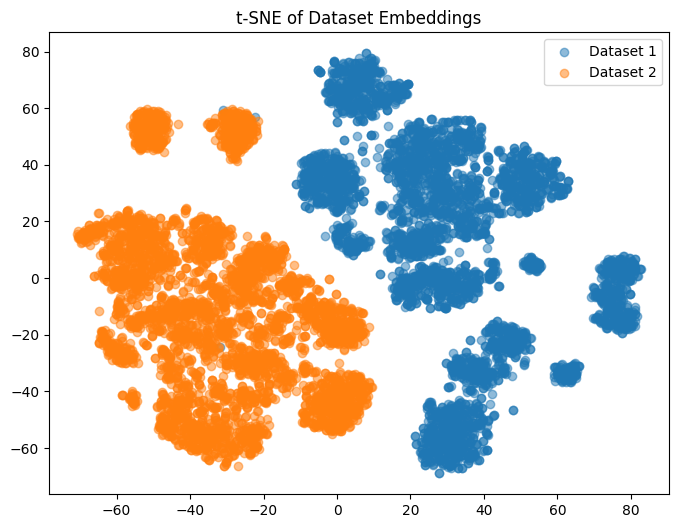

In [10]:
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()
model = model.to(device)
evaluate_dataset('data/evaluate/valid.csv', 'data/dataset_2.csv', model)


In [11]:
# Define the dataset and data loaders
train_dataset = CustomDataset(csv_file='data/train.csv', transform=transform)
val_dataset = CustomDataset(csv_file='data/valid.csv', transform=transform)
test_dataset = CustomDataset(csv_file='data/test.csv', transform=transform)

In [12]:
def get_gpu_dataloader(sampler, dataset,batch_size=1, shuffle=False):
    data = []
    labels = []
    for img, label in tqdm(dataset):
        data.append(img)
        labels.append(label)

    data = torch.stack(data)
    labels = torch.tensor(labels)

    data = data.to(device)
    labels = labels.to(device)

    loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(data, labels),
    batch_size=batch_size, shuffle=shuffle, sampler=sampler)
    return loader

In [13]:
def get_weighted_sampler(dataset):
   # WeightedRandomSampler against class imbalance
    labels = dataset.labels_df['Labels'].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weights = 1. / class_sample_count
    samples_weights = np.array([weights[int(t)] for t in labels])
    samples_weights = torch.from_numpy(samples_weights).float()

    return torch.utils.data.WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)
 

# Data loaders
train_sampler = get_weighted_sampler(train_dataset)
validation_sampler = get_weighted_sampler(val_dataset)

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=validation_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Data exploration

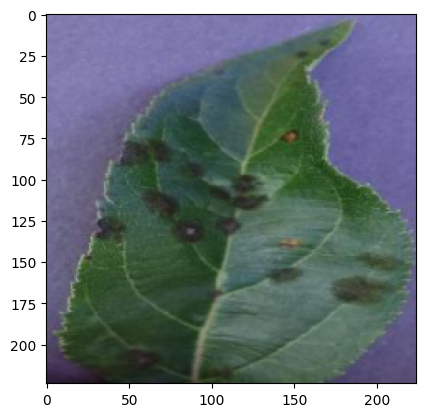

1.0
Number of samples in train_dataset: 81140
Number of samples in val_dataset_plant: 20283
Batch size: 64
Image shape (C, H, W): torch.Size([3, 224, 224])
Label example: 1.0


In [14]:
import torchvision.utils

import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataset)
next(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in val_dataset_plant: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Image shape (C, H, W): {images.shape}")
print(f"Label example: {labels}")

Train label distribution:
Labels
1    53370
0    27770
Name: count, dtype: int64

Validation label distribution:
Labels
1    13291
0     6992
Name: count, dtype: int64


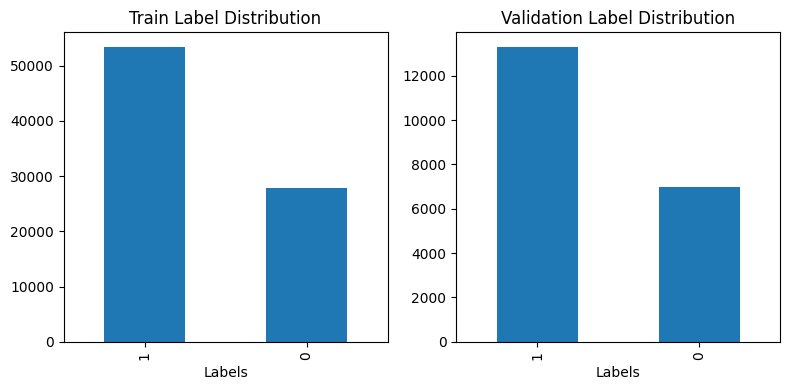

Weighted sampler batch label distribution (train):


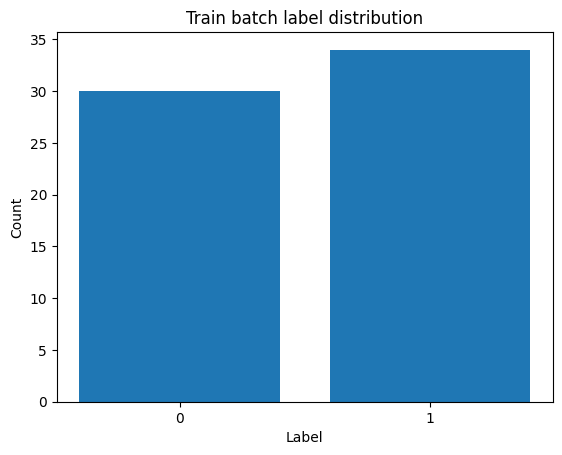

Weighted sampler batch label distribution (validation):


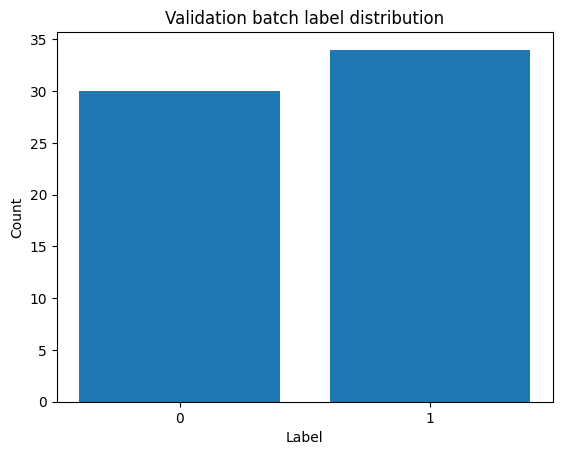

Sample image path: ../../../../.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG
Image mode: RGB
Image size (W x H): (256, 256)
Image format: JPEG
Image file size: 9.39 KB
Imbalance ratio (min/max): 0.520

Data augmentation in use:
- Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
- RandomHorizontalFlip(p=0.5)
- ToTensor()
- Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))


In [15]:
# Datenexploration: Qualität, Bitrate, Verteilung der Labels, Dimension, etc.

# Verteilung der Labels im Trainings- und Validierungsdatensatz
train_labels = train_dataset.labels_df['Labels']
val_labels = val_dataset.labels_df['Labels']

print("Train label distribution:")
print(train_labels.value_counts())
print("\nValidation label distribution:")
print(val_labels.value_counts())

# Plot label distribution
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
train_labels.value_counts().plot(kind='bar', title='Train Label Distribution')
plt.subplot(1, 2, 2)
val_labels.value_counts().plot(kind='bar', title='Validation Label Distribution')
plt.tight_layout()
plt.show()

# Show label distribution in a batch from the weighted sampler
def plot_batch_label_distribution(loader, name):
    batch_imgs, batch_labels = next(iter(loader))
    unique, counts = np.unique(batch_labels.cpu().numpy(), return_counts=True)
    plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
    plt.title(f"{name} batch label distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

print("Weighted sampler batch label distribution (train):")
plot_batch_label_distribution(training_loader, "Train")
print("Weighted sampler batch label distribution (validation):")
plot_batch_label_distribution(validation_loader, "Validation")

# Beispielbild: Qualität, Dimension, Bitrate
sample_img_path = train_dataset.labels_df.iloc[0]['Image']
sample_img = Image.open(sample_img_path)
print(f"Sample image path: {sample_img_path}")
print(f"Image mode: {sample_img.mode}")
print(f"Image size (W x H): {sample_img.size}")
print(f"Image format: {sample_img.format}")

# Bitrate (Dateigröße in KB)
img_size_kb = os.path.getsize(sample_img_path) / 1024
print(f"Image file size: {img_size_kb:.2f} KB")

# Check for class imbalance
imbalance_ratio = train_labels.value_counts().min() / train_labels.value_counts().max()
print(f"Imbalance ratio (min/max): {imbalance_ratio:.3f}")
if imbalance_ratio < 0.5:
    print("Warning: The dataset is imbalanced!")

# Data augmentation check
print("\nData augmentation in use:")
for t in transform.transforms:
    print("-", t)

## Models

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

            nn.Conv2d(16, 16, kernel_size=15, padding=7),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16 * int(width/(2**7)) * int(height/(2**7)), 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.reshape(-1)

## Training

In [17]:
def log_metrics_to_tensorboard(model_name, epoch, test_loss):
    writer.add_scalar(f'{model_name}/test_loss', test_loss, epoch)

def log_accuracy_to_tensorboard(model_name, epoch, accuracy):
    writer.add_scalar(f'{model_name}/accuracy', accuracy, epoch)

In [18]:
def train_model(model, optimizer, scheduler, criterion = nn.BCELoss(), num_epochs=1000):
    # Calculate the total number of parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total number of parameters: {total_params}')

    # Move the model to GPU if available
    print(device)
    model.to(device)

    # Training loop with early stopping
    patience = 2
    best_val_loss = float('inf')
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(training_loader, desc="Training"):
            images = images.to(device)
            labels = labels.to(device)
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.detach().item()

            # Backward pass
            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f'Training loss: {running_loss / len(training_loader)}')
        log_metrics_to_tensorboard('CNN', epoch, running_loss / len(training_loader))
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(validation_loader, desc="Validation"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Convert the outputs to predicted class labels
                predicted = (outputs>0.5).float() #torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        print(f'Validation loss: {val_loss / len(validation_loader)}')
        print(f'Validation accuracy: {val_accuracy:.4f}')
        log_accuracy_to_tensorboard('CNN', epoch, val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = patience_counter - 1 if patience_counter > 0 else 0
            torch.save(model.state_dict(), 'best_acc_model.pth')
            print(f'Best model saved with valid acc of {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_val_model.pth')
            print(f'Best model saved with valid loss of {val_loss / len(validation_loader)}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break


In [19]:

def eval(model):
    model.load_state_dict(torch.load('best_val_model.pth'))
    model.to(device)

    # Make predictions on the test dataset
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for images, label in tqdm(test_loader, desc="Test (eval)"):
            images = images.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            labels.extend(label.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    # Create a DataFrame with IDs and predictions
    submission_df = pd.DataFrame({
        #'images': test_dataset.labels_df['Images'],
        'labels': predictions,
        'groundtruth': labels
    })
    #submission_df.to_csv('submission.csv', index=False)
    #print('Submission file was created.')
    accuracy = (submission_df.labels == submission_df.groundtruth).mean()
    wrong_assesments = submission_df[submission_df.labels != submission_df.groundtruth]
    false_positives = len(wrong_assesments[wrong_assesments.groundtruth == 1])
    false_negatives = len(wrong_assesments[wrong_assesments.groundtruth == 0])
    print(f"We have {false_positives} false positives and {false_negatives} false negatives!")
    print(f"Accuracy: {accuracy:.4f}")
    return submission_df

In [20]:
import time
def inference_time(model):
    image, label = val_dataset[0]
    image = image.unsqueeze(0)
    model.cpu()
    since = time.time()
    model(image)
    now = time.time()
    now - since

In [21]:
model = CNN()

## Hyperparameters of CNNs

In [22]:
# Training specific hyperparameters
num_epochs = 1000
learning_rate = 0.001
criterion = nn.BCELoss() #  nn.CrossEntropyLoss(label_smoothing=0.1)
weight_decay = 0.0
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 

## Training start

In [23]:

# train_model(model, optimizer,scheduler, criterion, num_epochs=num_epochs)


## Evaluation

In [24]:
eval(model)
inference_time(model)

Test (eval):   0%|          | 0/53 [00:00<?, ?it/s]

Test (eval): 100%|██████████| 53/53 [06:34<00:00,  7.45s/it]

We have 218 false positives and 70 false negatives!
Accuracy: 0.9150


In [25]:
model.load_state_dict(torch.load('best_val_model.pth'))
model.to(device)
model.eval()
evaluate_dataset('data/evaluate/valid.csv', 'data/dataset_2.csv', model)


Extracting embeddings: 100%|██████████| 67/67 [09:12<00:00,  8.25s/it]


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

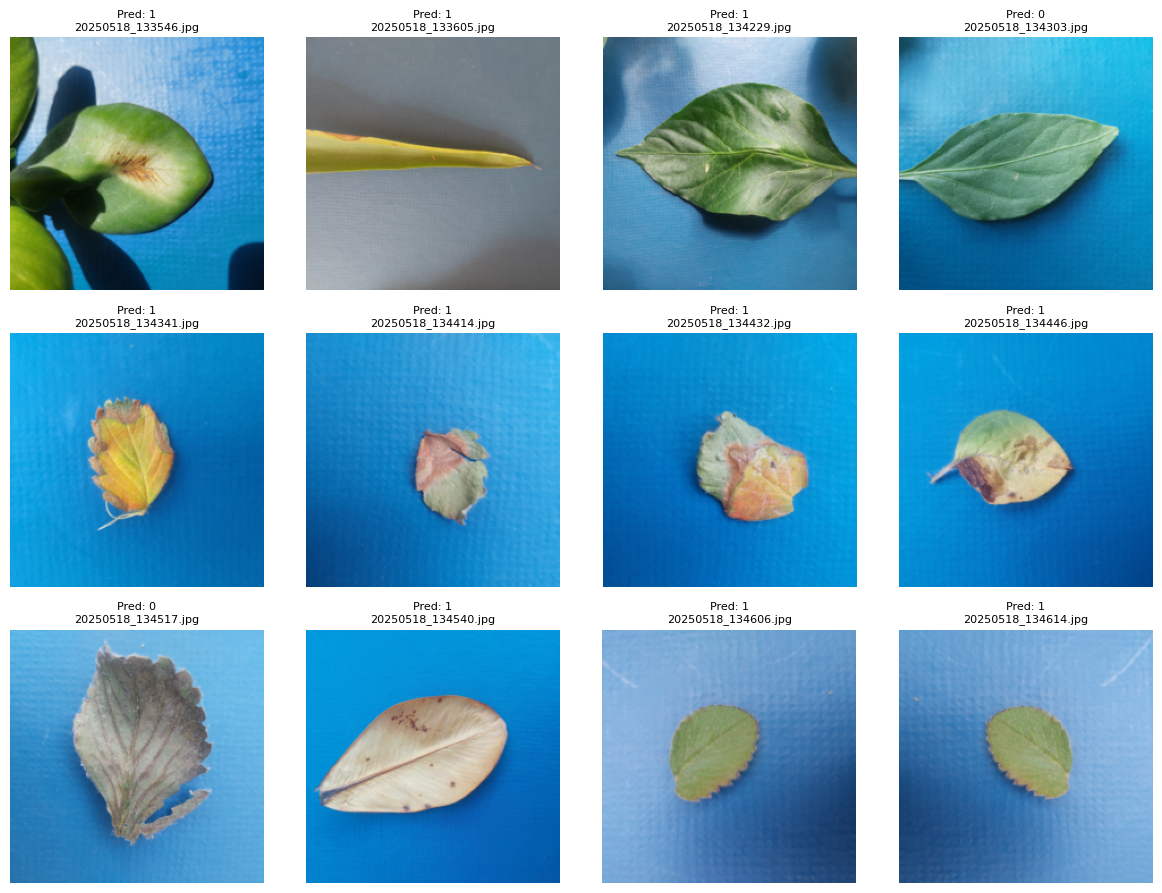

In [26]:
import glob

# 1. Get all image paths from the directory
image_paths = sorted(
    glob.glob('./data/selfmade-dataset/**/*.jpg', recursive=True) +
    glob.glob('./data/selfmade-dataset/**/*.jpeg', recursive=True) +
    glob.glob('./data/selfmade-dataset/**/*.png', recursive=True)
)

class UnlabeledImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path
    
selfmade_dataset = UnlabeledImageDataset(image_paths, transform=transform)
selfmade_loader = torch.utils.data.DataLoader(selfmade_dataset, batch_size=batch_size, shuffle=False)

def show_selfmade_predictions(model, selfmade_loader, max_images=16):
    model.load_state_dict(torch.load('best_val_model.pth'))
    model.to(device)
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 12))
    with torch.no_grad():
        for images, paths in selfmade_loader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float().cpu().numpy()
            for i in range(len(images)):
                if images_shown >= max_images:
                    plt.tight_layout()
                    plt.show()
                    return
                img = images[i].cpu().numpy()
                img = img / 2 + 0.5  # unnormalize if using Normalize((0.5,...), (0.5,...))
                img = np.transpose(img, (1, 2, 0))
                plt.subplot(4, 4, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {int(preds[i])}\n{os.path.basename(paths[i])}", fontsize=8)
                plt.axis('off')
                images_shown += 1
    plt.tight_layout()
    plt.show()

show_selfmade_predictions(model, selfmade_loader, max_images=16)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8627), started 0:00:22 ago. (Use '!kill 8627' to kill it.)